In [1]:
import pandas as pd
import numpy as np

from dateutil.parser import parse
from datetime import datetime
import dateutil.parser

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


import glob
import os
import zipfile

import timeit
import requests

from bs4 import BeautifulSoup
import re
import urllib
from bs4 import BeautifulSoup, element

import nltk

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

import statsmodels.api as sm

In [2]:
# read in twitch streaming data
twitch_df = pd.read_csv("twitch1000.csv")

In [3]:
# format columns 
twitch_df.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [4]:
twitch_df.columns


Index(['game', 'watch_time', 'stream_time', 'peak_viewers', 'peak_channels',
       'streamers', 'average_viewers', 'average_channels',
       'average_viewer_ratio', 'followers_gained', 'views_gained'],
      dtype='object')

In [5]:
# look at datatype in file
twitch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
game                    1000 non-null object
watch_time              1000 non-null int64
stream_time             1000 non-null int64
peak_viewers            1000 non-null int64
peak_channels           1000 non-null int64
streamers               1000 non-null int64
average_viewers         1000 non-null int64
average_channels        1000 non-null int64
average_viewer_ratio    1000 non-null float64
followers_gained        1000 non-null int64
views_gained            1000 non-null int64
dtypes: float64(1), int64(9), object(1)
memory usage: 86.0+ KB


In [6]:
twitch_df.head()

,game,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio,followers_gained,views_gained
0,Fortnite,81482934840,4774106760,1460297,34564,4058092,155046,9084,17.07,0,0
1,League of Legends,59122841100,1114259940,1147825,4981,768957,112499,2120,53.06,0,0
2,Dota 2,28344889140,308675820,749471,1473,185617,53934,587,91.83,0,0
3,PLAYERUNKNOWN'S BATTLEGROUNDS,27249424560,1058021220,579861,6473,855370,51850,2013,25.76,0,0
4,Counter-Strike: Global Offensive,24106519440,521227980,1298358,3173,680351,45869,991,46.25,0,0


In [7]:
# lower-case the game column for integration into sales_df
twitch_df['game'] = twitch_df['game'].str.lower()

In [8]:
twitch_df.head()

,game,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio,followers_gained,views_gained
0,fortnite,81482934840,4774106760,1460297,34564,4058092,155046,9084,17.07,0,0
1,league of legends,59122841100,1114259940,1147825,4981,768957,112499,2120,53.06,0,0
2,dota 2,28344889140,308675820,749471,1473,185617,53934,587,91.83,0,0
3,playerunknown's battlegrounds,27249424560,1058021220,579861,6473,855370,51850,2013,25.76,0,0
4,counter-strike: global offensive,24106519440,521227980,1298358,3173,680351,45869,991,46.25,0,0


## Combining Twitch With VGChartz

In [9]:
# bring in vg chart data from url
url = 'http://www.vgchartz.com/yearly/2018/Global/'

response = requests.get(url)

In [10]:
tables = pd.read_html(url)

In [11]:
# convert list object to a dataframe 
sales_df = pd.DataFrame(tables[1])

In [12]:
# take out columns that are not needed for analysis
columns = ['Pos', 'Game.1', 'Game.2']
sales_df = sales_df.drop(columns, axis=1)

In [13]:
# function to clean game title data 
def game_title(game):
    return game.split('(')[0].strip()

In [14]:
# Apply a function to format game title 
sales_df['Game'] = sales_df['Game'].apply(game_title)

In [15]:
# lower case the game rows so that they are compatible with Twitch dataframe
sales_df['Game'] = sales_df['Game'].str.lower()

In [16]:
# format columns in lowercase
sales_df.columns = [x.lower() for x in sales_df.columns]

In [17]:
# group by game title to sum unit sales per game (currently broken down by platform)
sales_df = sales_df.groupby(['game'])['yearly'].sum().reset_index()

In [18]:
combined_df = pd.merge(sales_df, twitch_df, on='game')

In [19]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 12 columns):
game                    51 non-null object
yearly                  51 non-null int64
watch_time              51 non-null int64
stream_time             51 non-null int64
peak_viewers            51 non-null int64
peak_channels           51 non-null int64
streamers               51 non-null int64
average_viewers         51 non-null int64
average_channels        51 non-null int64
average_viewer_ratio    51 non-null float64
followers_gained        51 non-null int64
views_gained            51 non-null int64
dtypes: float64(1), int64(10), object(1)
memory usage: 5.2+ KB


In [20]:
combined_df.head(50)

,game,yearly,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio,followers_gained,views_gained
0,assassin's creed odyssey,4564139,906306720,23675880,105475,1221,49923,1724,45,38.28,0,0
1,assassin's creed origins,1492024,91219080,12902040,9910,146,51845,173,24,7.07,0,0
2,battlefield v,3771595,1096354260,37610460,277175,1825,102702,2086,71,29.15,0,0
3,call of duty: wwii,2526194,1460401200,57987540,148960,547,265061,2778,110,25.18,0,0
4,destiny 2,755874,4211079600,322508760,181929,8097,324038,8012,613,13.06,0,0
5,detroit: become human,1572826,912724080,11670780,236767,856,44040,1736,22,78.21,0,0
6,donkey kong country: tropical freeze,1691822,55067940,911760,68273,74,2535,104,1,60.40,0,0
7,dragon quest xi,620347,176274420,7360020,23595,456,7802,335,14,23.95,0,0
8,ea sports ufc 3,969422,133819560,2339160,145154,77,18108,254,4,57.21,0,0
9,fallout 4,568545,432939660,52021260,20372,290,95577,823,98,8.32,0,0


In [21]:
combined_df.shape

(51, 12)

In [22]:
combined_df = combined_df.drop(columns=['followers_gained', 'views_gained'])


## Visualizing with Seaborn

In [23]:
combined_df.corr()

,yearly,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
yearly,1.000000,-0.030101,-0.037997,0.137323,0.158021,-0.021217,-0.030103,-0.037958,0.045481
watch_time,-0.030101,1.000000,0.989905,0.925761,0.918345,0.984976,1.000000,0.989909,-0.094106
stream_time,-0.037997,0.989905,1.000000,0.912171,0.937487,0.993867,0.989905,1.000000,-0.111284
peak_viewers,0.137323,0.925761,0.912171,1.000000,0.919058,0.916804,0.925761,0.912176,-0.074718
peak_channels,0.158021,0.918345,0.937487,0.919058,1.000000,0.932758,0.918344,0.937491,-0.140026
streamers,-0.021217,0.984976,0.993867,0.916804,0.932758,1.000000,0.984976,0.993862,-0.131022
average_viewers,-0.030103,1.000000,0.989905,0.925761,0.918344,0.984976,1.000000,0.989908,-0.094111
average_channels,-0.037958,0.989909,1.000000,0.912176,0.937491,0.993862,0.989908,1.000000,-0.111245
average_viewer_ratio,0.045481,-0.094106,-0.111284,-0.074718,-0.140026,-0.131022,-0.094111,-0.111245,1.000000


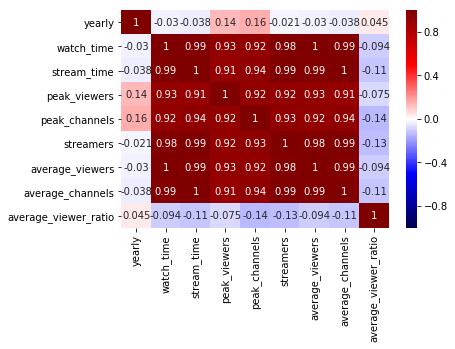

In [24]:
sns.heatmap(combined_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);


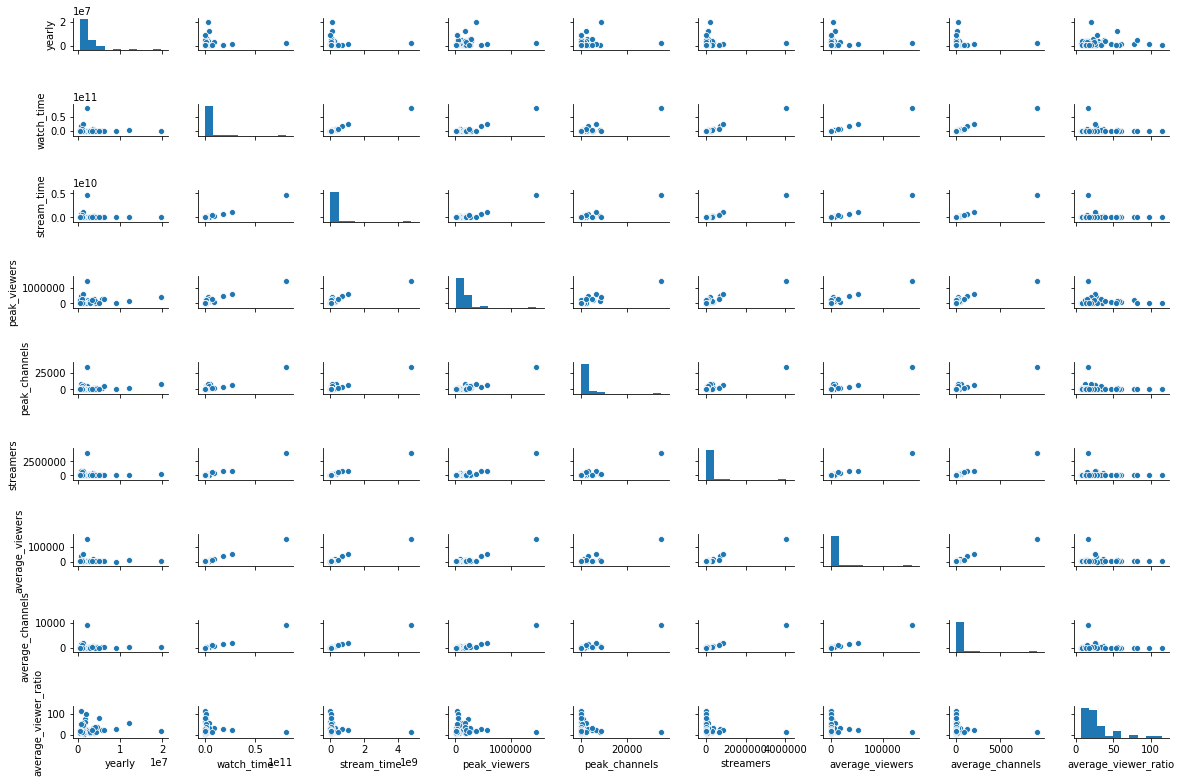

In [25]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(combined_df, height=1.2, aspect=1.5);

In [26]:
# Define the model
lm1 = smf.ols('yearly ~ watch_time + stream_time + peak_viewers + peak_channels + streamers + average_viewers + average_channels + average_viewer_ratio', data=combined_df)

# Fit the model
fit = lm1.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yearly   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     3.409
Date:                Mon, 15 Jul 2019   Prob (F-statistic):            0.00418
Time:                        22:48:52   Log-Likelihood:                -824.92
No. Observations:                  51   AIC:                             1668.
Df Residuals:                      42   BIC:                             1685.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.164e+06   1.34e+06      0.872      0.388   -1.53e+06    3.86e+06
watch_time               1.4542      3.059      0.475      0.637      -4.719       7.628
stream_time             -3.2673      2.789     -1.171      0.248      -8.896       2.362
peak_viewers             4.7429      6.177      0.768      0.447      -7.723      17.209
peak_channels          923.8690    304.753      3.032      0.004     308.852    1538.886
streamers                7.8940      6.689      1.180      0.245      -5.605      21.393
average_viewers      -7.641e+05   1.61e+06     -0.475      0.637   -4.01e+06    2.48e+06
average_channels      1.708e+06   1.47e+06      1.165      0.250   -1.25e+06    4.67e+06
average_viewer_ratio  7701.2452   2.01e+04      0.383      0.704   -3.29e+04    4.83e+04
==============================================================================
Omnibus:                       17.267   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.122
Skew:                           1.037   Prob(JB):                     7.82e-07
Kurtosis:                       5.988   Cond. No.                     6.00e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  6e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now, let's take out our highest P scores and see if we get a better R2.

In [27]:
# Define the model
lm1 = smf.ols('yearly ~ stream_time + peak_viewers + peak_channels + streamers + average_channels', data=combined_df)

# Fit the model
fit2 = lm1.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yearly   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     5.543
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           0.000464
Time:                        22:48:52   Log-Likelihood:                -825.45
No. Observations:                  51   AIC:                             1663.
Df Residuals:                      45   BIC:                             1674.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.935e+06   9.11e+05      2.125      0.039    1.01e+05    3.77e+06
stream_time         -3.6361      2.669     -1.362      0.180      -9.012       1.740
peak_viewers         6.2416      4.899      1.274      0.209      -3.626      16.109
peak_channels      875.5362    247.814      3.533      0.001     376.413    1374.660
streamers            6.6098      6.363      1.039      0.304      -6.206      19.426
average_channels  1.904e+06    1.4e+06      1.358      0.181   -9.21e+05    4.73e+06
==============================================================================
Omnibus:                       19.481   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.928
Skew:                           1.147   Prob(JB):                     4.29e-08
Kurtosis:                       6.271   Cond. No.                     2.87e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.87e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

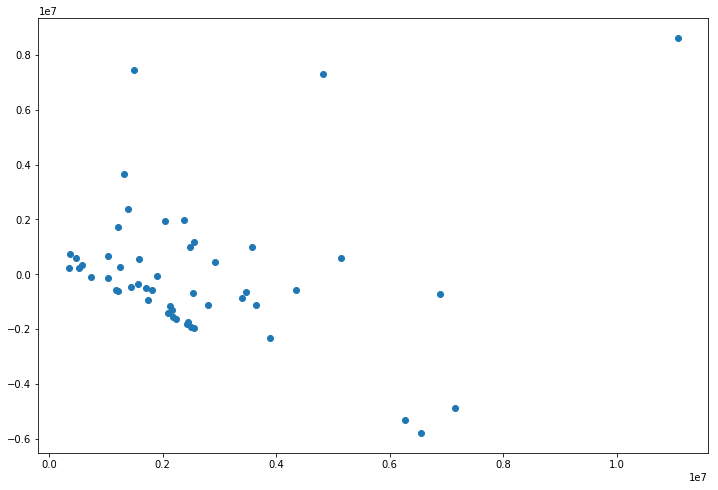

In [28]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(12,8))
plt.scatter(fit2.predict(), fit2.resid);

We can see from this plot that we don't have a strong linear model. Going back to our original dataset, we should look at some of the extreme outliers. Using some domain knowledge we see that the top three games from a streaming perspective are Fortnite, PUBG and Overwatch. These are free to play games (that had small console releases after the fact) so aren't really representative of real sales numbers. Let's take them out of the dataset and see what happens. 

In [29]:
combined_df.head()

,game,yearly,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
0,assassin's creed odyssey,4564139,906306720,23675880,105475,1221,49923,1724,45,38.28
1,assassin's creed origins,1492024,91219080,12902040,9910,146,51845,173,24,7.07
2,battlefield v,3771595,1096354260,37610460,277175,1825,102702,2086,71,29.15
3,call of duty: wwii,2526194,1460401200,57987540,148960,547,265061,2778,110,25.18
4,destiny 2,755874,4211079600,322508760,181929,8097,324038,8012,613,13.06


In [30]:
# drop fortnite, PUBG and Overwatch
combined_df = combined_df.drop([0, 1, 2])


In [31]:
combined_df

,game,yearly,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
3,call of duty: wwii,2526194,1460401200,57987540,148960,547,265061,2778,110,25.18
4,destiny 2,755874,4211079600,322508760,181929,8097,324038,8012,613,13.06
5,detroit: become human,1572826,912724080,11670780,236767,856,44040,1736,22,78.21
6,donkey kong country: tropical freeze,1691822,55067940,911760,68273,74,2535,104,1,60.40
7,dragon quest xi,620347,176274420,7360020,23595,456,7802,335,14,23.95
8,ea sports ufc 3,969422,133819560,2339160,145154,77,18108,254,4,57.21
9,fallout 4,568545,432939660,52021260,20372,290,95577,823,98,8.32
10,fallout 76,2253016,1003438260,45400500,209140,5476,73330,1909,86,22.10
11,far cry 5,5732896,932290500,38185860,258270,2864,131504,1773,72,24.41
12,farming simulator 19,583425,200210100,9107340,44919,783,12756,380,17,21.98


In [32]:
combined_df.corr()

,yearly,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
yearly,1.000000,-0.028217,-0.035769,0.133217,0.159159,-0.018893,-0.028219,-0.035734,0.035301
watch_time,-0.028217,1.000000,0.989892,0.932303,0.918373,0.984967,1.000000,0.989895,-0.099658
stream_time,-0.035769,0.989892,1.000000,0.918957,0.937724,0.993874,0.989891,1.000000,-0.116081
peak_viewers,0.133217,0.932303,0.918957,1.000000,0.922876,0.922943,0.932303,0.918963,-0.086848
peak_channels,0.159159,0.918373,0.937724,0.922876,1.000000,0.932880,0.918372,0.937729,-0.148476
streamers,-0.018893,0.984967,0.993874,0.922943,0.932880,1.000000,0.984967,0.993870,-0.136019
average_viewers,-0.028219,1.000000,0.989891,0.932303,0.918372,0.984967,1.000000,0.989895,-0.099663
average_channels,-0.035734,0.989895,1.000000,0.918963,0.937729,0.993870,0.989895,1.000000,-0.116045
average_viewer_ratio,0.035301,-0.099658,-0.116081,-0.086848,-0.148476,-0.136019,-0.099663,-0.116045,1.000000


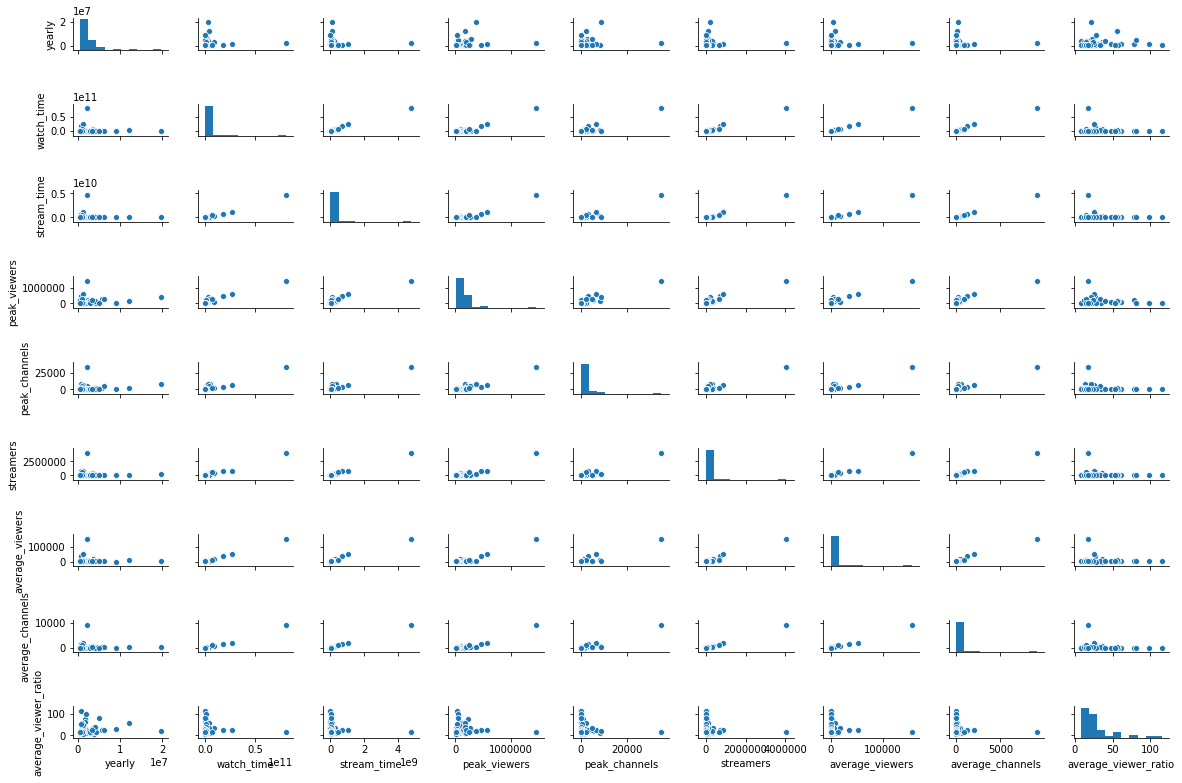

In [33]:
sns.pairplot(combined_df, height=1.2, aspect=1.5);

In [34]:
# Define the model
lm1 = smf.ols('yearly ~ watch_time + stream_time + peak_viewers + peak_channels + streamers + average_viewers + average_channels + average_viewer_ratio', data=combined_df)

# Fit the model
fit3 = lm1.fit()

# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yearly   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     3.105
Date:                Mon, 15 Jul 2019   Prob (F-statistic):            0.00826
Time:                        22:48:57   Log-Likelihood:                -777.76
No. Observations:                  48   AIC:                             1574.
Df Residuals:                      39   BIC:                             1590.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              1.05e+06   1.42e+06      0.742      0.463   -1.81e+06    3.91e+06
watch_time               1.4474      3.225      0.449      0.656      -5.076       7.971
stream_time             -3.0234      2.960     -1.021      0.313      -9.011       2.964
peak_viewers             4.8787      6.679      0.730      0.469      -8.631      18.388
peak_channels          924.1163    317.073      2.915      0.006     282.776    1565.457
streamers                7.8768      6.938      1.135      0.263      -6.157      21.910
average_viewers      -7.606e+05    1.7e+06     -0.449      0.656   -4.19e+06    2.67e+06
average_channels       1.58e+06   1.56e+06      1.016      0.316   -1.57e+06    4.73e+06
average_viewer_ratio  7992.1047   2.11e+04      0.378      0.707   -3.47e+04    5.07e+04
==============================================================================
Omnibus:                       16.169   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.984
Skew:                           1.045   Prob(JB):                     6.19e-06
Kurtosis:                       5.761   Cond. No.                     6.12e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.12e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interesting...we do get a higher R2 value but we still aren't looking great. As before let's drop our highest P values and see how things look.

In [35]:
# Define the model
lm1 = smf.ols('yearly ~ stream_time + peak_viewers + peak_channels + streamers + average_channels', data=combined_df)

# Fit the model
fit4 = lm1.fit()

# Print summary statistics of the model's performance
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yearly   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     5.076
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           0.000996
Time:                        22:48:57   Log-Likelihood:                -778.24
No. Observations:                  48   AIC:                             1568.
Df Residuals:                      42   BIC:                             1580.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.824e+06   9.78e+05      1.866      0.069   -1.49e+05     3.8e+06
stream_time         -3.3833      2.830     -1.196      0.239      -9.095       2.328
peak_viewers         6.6191      5.291      1.251      0.218      -4.060      17.298
peak_channels      871.2322    256.645      3.395      0.002     353.302    1389.162
streamers            6.5527      6.575      0.997      0.325      -6.716      19.821
average_channels  1.771e+06   1.49e+06      1.191      0.240   -1.23e+06    4.77e+06
==============================================================================
Omnibus:                       17.907   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.181
Skew:                           1.133   Prob(JB):                     7.59e-07
Kurtosis:                       5.993   Cond. No.                     2.96e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.96e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's go back to our domain knowledge before we move on to different models and feature engineering. We can likely take out some more titles that are influencing the charts. 
- Rainbow Six Siege still sees huge numbers but came out in 2015 so let's take that out. 
- Similarly, Rocket League came out in 2014 yet is one of the top streamed games with small sales. 
- Finally, let's take out outdated sports games. We see just as high number for 2018 titles in streaming but lower sales compared to 2019 which came out in the year we are studying

In [36]:
# drop rainbow six, rocket league, sports games from 2017 releases and the older assassin's creed
combined_df = combined_df.drop([4, 9, 10, 20, 43])

In [37]:
combined_df

,game,yearly,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
3,call of duty: wwii,2526194,1460401200,57987540,148960,547,265061,2778,110,25.18
5,detroit: become human,1572826,912724080,11670780,236767,856,44040,1736,22,78.21
6,donkey kong country: tropical freeze,1691822,55067940,911760,68273,74,2535,104,1,60.40
7,dragon quest xi,620347,176274420,7360020,23595,456,7802,335,14,23.95
8,ea sports ufc 3,969422,133819560,2339160,145154,77,18108,254,4,57.21
11,far cry 5,5732896,932290500,38185860,258270,2864,131504,1773,72,24.41
12,farming simulator 19,583425,200210100,9107340,44919,783,12756,380,17,21.98
13,fifa 18,1690579,2568628500,83343960,143683,1216,179312,4887,158,30.82
14,fifa 19,12119202,3754793940,67330620,167405,2400,135361,7144,128,55.77
15,fortnite,2129191,81482934840,4774106760,1460297,34564,4058092,155046,9084,17.07


In [38]:
combined_df.corr()

,yearly,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
yearly,1.000000,-0.040035,-0.043842,0.118572,0.167533,-0.028046,-0.040038,-0.043816,0.063754
watch_time,-0.040035,1.000000,0.990187,0.935832,0.938276,0.985234,1.000000,0.990189,-0.103644
stream_time,-0.043842,0.990187,1.000000,0.922977,0.954550,0.993922,0.990187,1.000000,-0.121344
peak_viewers,0.118572,0.935832,0.922977,1.000000,0.934461,0.926682,0.935832,0.922977,-0.073263
peak_channels,0.167533,0.938276,0.954550,0.934461,1.000000,0.949659,0.938275,0.954554,-0.130473
streamers,-0.028046,0.985234,0.993922,0.926682,0.949659,1.000000,0.985234,0.993917,-0.138906
average_viewers,-0.040038,1.000000,0.990187,0.935832,0.938275,0.985234,1.000000,0.990189,-0.103649
average_channels,-0.043816,0.990189,1.000000,0.922977,0.954554,0.993917,0.990189,1.000000,-0.121286
average_viewer_ratio,0.063754,-0.103644,-0.121344,-0.073263,-0.130473,-0.138906,-0.103649,-0.121286,1.000000


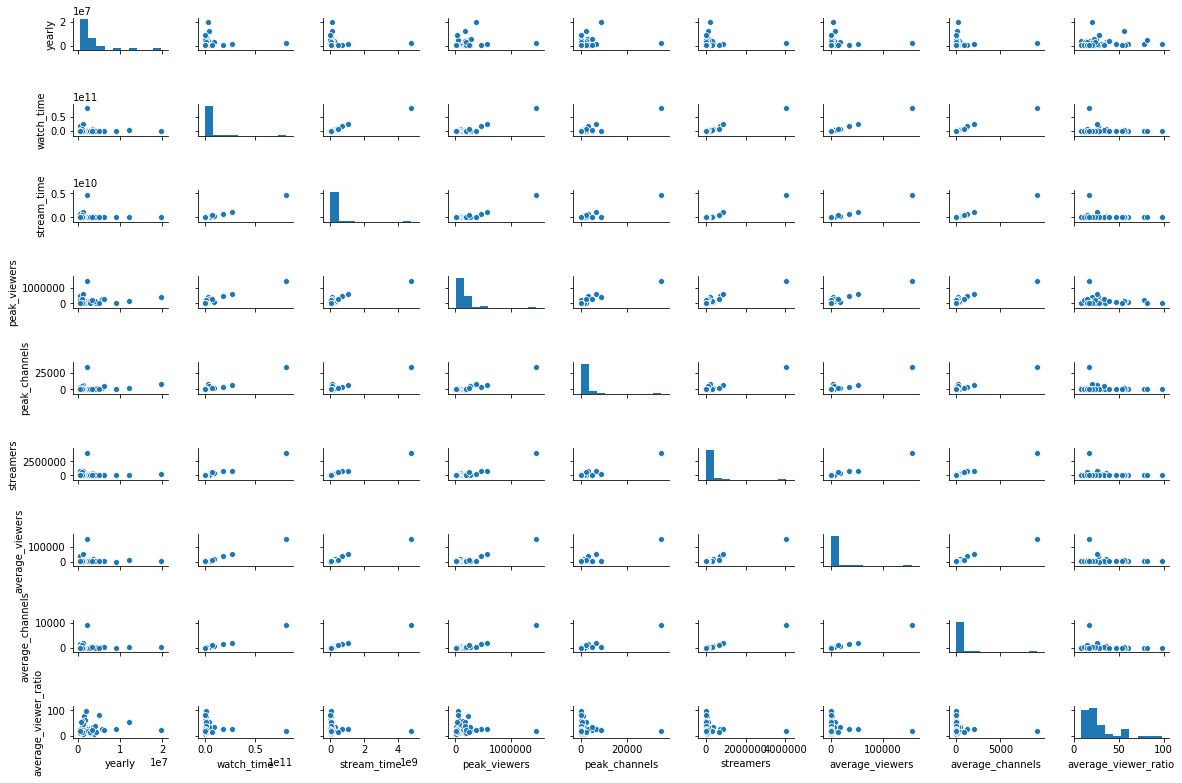

In [39]:
sns.pairplot(combined_df, height=1.2, aspect=1.5);

In [40]:
# Define the model
lm1 = smf.ols('yearly ~ watch_time + stream_time + peak_viewers + peak_channels + streamers + average_viewers + average_channels + average_viewer_ratio', data=combined_df)

# Fit the model
fit4 = lm1.fit()

# Print summary statistics of the model's performance
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yearly   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     5.058
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           0.000344
Time:                        22:49:02   Log-Likelihood:                -692.22
No. Observations:                  43   AIC:                             1402.
Df Residuals:                      34   BIC:                             1418.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.146e+06   1.42e+06      0.807      0.425   -1.74e+06    4.03e+06
watch_time               0.4218      3.137      0.134      0.894      -5.954       6.797
stream_time             -1.7876      2.962     -0.604      0.550      -7.806       4.231
peak_viewers            -0.5060      6.371     -0.079      0.937     -13.454      12.442
peak_channels         1587.9281    344.510      4.609      0.000     887.800    2288.056
streamers                7.5395      6.366      1.184      0.244      -5.398      20.477
average_viewers      -2.215e+05   1.65e+06     -0.134      0.894   -3.57e+06    3.13e+06
average_channels       9.28e+05   1.56e+06      0.596      0.555   -2.23e+06    4.09e+06
average_viewer_ratio  1.334e+04   2.36e+04      0.565      0.576   -3.47e+04    6.13e+04
==============================================================================
Omnibus:                       11.993   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               22.460
Skew:                           0.614   Prob(JB):                     1.33e-05
Kurtosis:                       6.321   Cond. No.                     6.73e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.73e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
# Define the model
lm1 = smf.ols('yearly ~ stream_time + peak_channels + streamers + average_channels', data=combined_df)

# Fit the model
fit5 = lm1.fit()

# Print summary statistics of the model's performance
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yearly   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     10.38
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           8.80e-06
Time:                        23:27:11   Log-Likelihood:                -693.20
No. Observations:                  43   AIC:                             1396.
Df Residuals:                      38   BIC:                             1405.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.031e+06   8.32e+05      2.442      0.019    3.47e+05    3.71e+06
stream_time         -2.6812      2.733     -0.981      0.333      -8.214       2.851
peak_channels     1524.4396    248.268      6.140      0.000    1021.847    2027.032
streamers            7.4100      5.859      1.265      0.214      -4.452      19.271
average_channels    1.4e+06   1.44e+06      0.975      0.336   -1.51e+06    4.31e+06
==============================================================================
Omnibus:                       12.413   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.893
Skew:                           0.808   Prob(JB):                     0.000130
Kurtosis:                       5.716   Cond. No.                     3.07e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

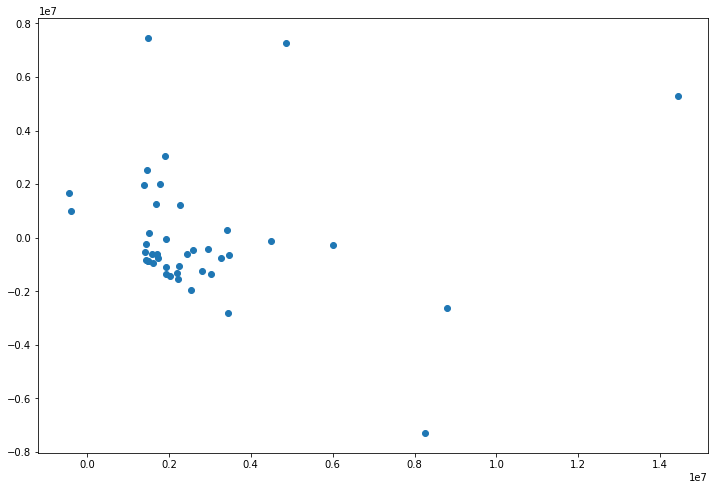

In [59]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(12,8))
plt.scatter(fit6.predict(), fit6.resid);

In [54]:
# Define the model
lm1 = smf.ols('yearly ~ stream_time + peak_channels + streamers', data=combined_df)

# Fit the model
fit6 = lm1.fit()

# Print summary statistics of the model's performance
fit6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yearly   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     13.54
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           3.35e-06
Time:                        23:16:00   Log-Likelihood:                -693.73
No. Observations:                  43   AIC:                             1395.
Df Residuals:                      39   BIC:                             1403.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        1.4e+06   5.23e+05      2.678      0.011    3.43e+05    2.46e+06
stream_time      -0.0162      0.005     -3.159      0.003      -0.027      -0.006
peak_channels  1542.7996    247.397      6.236      0.000    1042.392    2043.208
streamers         6.2126      5.726      1.085      0.285      -5.368      17.794
==============================================================================
Omnibus:                       14.585   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.786
Skew:                           0.878   Prob(JB):                     4.15e-06
Kurtosis:                       6.278   Cond. No.                     1.01e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now let's bring in sklearn as well as perform some transformations on the data.

In [43]:
#Separate our features from our target

X = combined_df.loc[:,['watch_time', 'stream_time', 'peak_viewers', 
                      'peak_channels', 'streamers', 'average_viewers', 
                      'average_channels', 'average_viewer_ratio']] 

y = combined_df['yearly']

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 3 to 50
Data columns (total 8 columns):
watch_time              43 non-null int64
stream_time             43 non-null int64
peak_viewers            43 non-null int64
peak_channels           43 non-null int64
streamers               43 non-null int64
average_viewers         43 non-null int64
average_channels        43 non-null int64
average_viewer_ratio    43 non-null float64
dtypes: float64(1), int64(7)
memory usage: 4.3 KB
